In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from dataset.dialogue_graph_datamodule import SubDialogueDataModule
import torch 
from tqdm import tqdm
from model import GiBERTino

model = GiBERTino.load_from_checkpoint("./giBERTino-alibaba-GCN-STAC-epoch=29-val_loss=1.58.ckpt")

model.eval()
data_module = SubDialogueDataModule("data/STAC/alibaba-graphs", num_workers=0)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Processing test data"):
        link_logits, rel_probs = model(batch)

        link_labels = batch[('edu', 'to', 'edu')].get('link_labels', None)
        rel_labels = batch[('edu', 'to', 'edu')].get('rel_labels', None)
        break

2025-05-31 17:45:15.043289: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-31 17:45:29,265 - INFO - Use pytorch device_name: cpu
2025-05-31 17:45:29,267 - INFO - Load pretrained SentenceTransformer: Alibaba-NLP/gte-modernbert-base
Processing...
Done!
Processing test data:   0%|          | 0/1 [00:00<?, ?it/s]


Subgraph 1: interval [0:11] produces 11 nodes with edges, 15 edges
Subgraph 1: created graph with 11 nodes and 15 edges


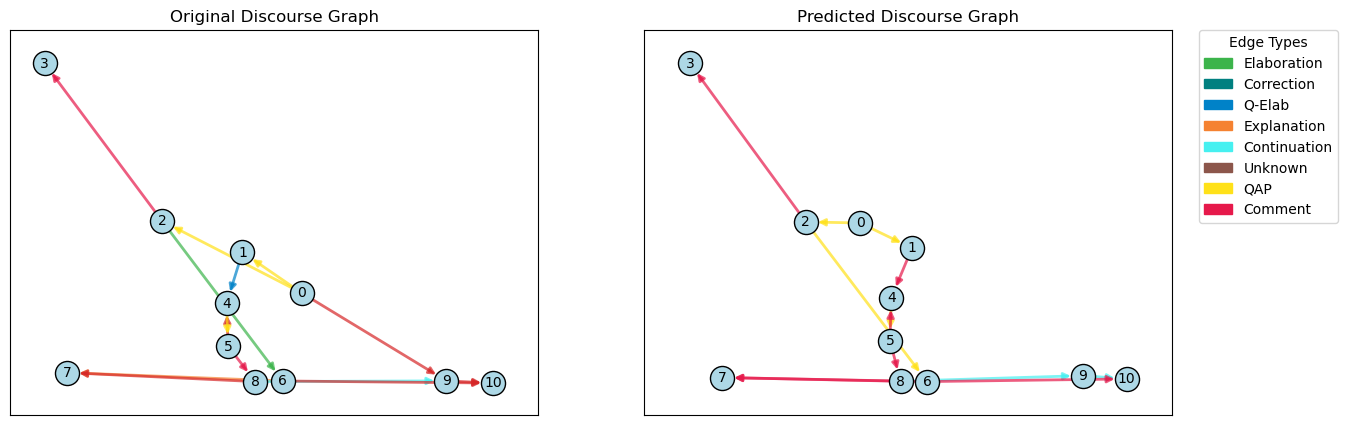

In [3]:
from torch_geometric.data import HeteroData
import torch
from utils.constants import RELATIONS
from utils import create_graph_from_predictions

ptr = batch['edu'].ptr
num_subgraphs = ptr.size(0)

for j in range(1, num_subgraphs):  # start from 1 because j=0 is empty
    start_idx = ptr[j - 1].item()
    end_idx   = ptr[j].item()

    # 1) FIRST: mask all possible nodes in this subgraph
    node_mask = torch.zeros(batch['edu'].num_nodes, dtype=torch.bool, device=batch['edu'].x.device)
    node_mask[start_idx:end_idx] = True

    # Extract all POSSIBLE edges in the batch
    src_all, dst_all = batch['edu', 'to', 'edu'].edge_index

    # 2) Compute which edges fall entirely within [start..end)
    edge_mask = node_mask[src_all] & node_mask[dst_all]
    if edge_mask.sum().item() == 0:
        print(f"Subgraph {j}: zero edges filtered → skipping to next")
        continue

    # 3) Find the nodes that are used by at least one selected edge
    src_sel = src_all[edge_mask]
    dst_sel = dst_all[edge_mask]
    unique_nodes = torch.unique(torch.cat([src_sel, dst_sel]))

    # 4) Rebuild the mask for “only nodes with edges”
    final_node_mask = torch.zeros_like(node_mask)
    final_node_mask[unique_nodes] = True

    # DEBUG: see how many actual nodes and how many edges you have
    print(
        f"Subgraph {j}: interval [{start_idx}:{end_idx}] produces "
        f"{final_node_mask.sum().item()} nodes with edges, "
        f"{edge_mask.sum().item()} edges"
    )

    # 5) Build the actual subgraph using only those nodes
    g = HeteroData()
    g['edu'].x = batch['edu'].x[final_node_mask]
    g['edu'].edus = batch['edu'].edus['input_ids'][final_node_mask]

    # Note: edge_index must be re-indexed to match a new 0-based index for g['edu'].x
    # We need to map unique_nodes → 0..(N_eff-1)
    perm = {int(n.item()): idx_new for idx_new, n in enumerate(unique_nodes)}

    # Build the local edge_index
    src_rel = []
    dst_rel = []
    for (s, d), keep in zip(batch['edu', 'to', 'edu'].edge_index.t().tolist(), edge_mask.tolist()):
        if not keep:
            continue
        src_rel.append(perm[s])
        dst_rel.append(perm[d])
    edge_index_local = torch.tensor([src_rel, dst_rel], dtype=torch.long)

    g['edu', 'to', 'edu'].edge_index = edge_index_local
    g['edu', 'to', 'edu'].rel_labels  = batch['edu', 'to', 'edu'].rel_labels[edge_mask]
    g['edu', 'to', 'edu'].link_labels = batch['edu', 'to', 'edu'].link_labels[edge_mask]

    # 6) Predictions only for those edges
    rel_preds = rel_probs[edge_mask]
    link_preds = link_logits[edge_mask]

    relations = RELATIONS["UNIFIED"]
    graph = create_graph_from_predictions(g, relations, link_preds, rel_preds)

    print(
        f"Subgraph {j}: created graph with {g['edu'].x.size(0)} nodes and "
        f"{edge_index_local.size(1)} edges"
    )

In [5]:
import networkx as nx
from torch_geometric.utils import to_networkx

from utils import create_gif_from_graphs

new_graph = to_networkx(graph, to_undirected=False)

all_paths = []

for src in new_graph.nodes:
    for dst in new_graph.nodes:
        if src != dst:
            paths = list(nx.all_simple_paths(new_graph, source=src, target=dst))
            all_paths.extend(paths)
            
create_gif_from_graphs(g, graph, all_paths)

GIF successfully created: graph_evolution.gif


'graph_evolution.gif'